In [1]:
# Script to generate uncorrelated models for a mechanism

In [2]:
# note, avoids deepcopy due to some issues copying

In [4]:
import os
import sys
import copy
import pickle

import numpy as np
import rmgpy.chemkin

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# hooks for parallelizing
# models_per_script = 100
# model_num = int(sys.argv[1])
models_per_script = 1
model_num = 0


In [7]:
# Load the model and the saved uncertainty covariance matrix.
# Only looks at uncorrelated parameters, so you can fill the
# diagonal of a zero matrix and get the same results as using
# the full covariance matrix

basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
model_dir = '/scratch/harris.se/autoscience/uncorrelated/models'  # where the output cti's go

base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
# RMG_cti_path = os.path.join(basedir, 'chem_annotated.cti')

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)
# RMG_gas = ct.Solution(RMG_cti_path)


covariance_file = '/work/westgroup/harris.se/autoscience/autoscience/uncertainty/butane_covariance.pickle'
with open(covariance_file, 'rb') as handle:
    Sigma_k = pickle.load(handle)


In [8]:
print(len(reaction_list))

1822


In [5]:
def perturb_reaction(rxn, delta):
    # takes in an RMG reaction object
    # delta is the ln(k) amount to perturb the A factor
    # delta is a multiplicative factor- units don't matter, yay!
    # does not deepycopy because there's some issues with rmgpy.reactions copying

    rxn.kinetics.A.value *= np.exp(delta)

#     return rxn

In [6]:
def plot_reaction_perturbation(original_reaction, perturbed_reaction, uncertainty):
    # function to show how the reaction kinetics have been changed
    
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    T = np.linspace(300, 3000, 1001)

    k_orig = np.zeros(len(T))
    k_perturb = np.zeros(len(T))
    for i in range(0, len(T)):
        k_orig[i] = original_reaction.kinetics.get_rate_coefficient(T[i], 101325)
        k_perturb[i] = perturbed_reaction.kinetics.get_rate_coefficient(T[i], 101325)
    plt.plot(1000.0 / T, np.log(k_orig))
    plt.plot(1000.0 / T, np.log(k_perturb))
    
    plt.plot(1000.0 / T, np.log(k_orig) + uncertainty, color='grey')
    plt.plot(1000.0 / T, np.log(k_orig) - uncertainty, color='grey')

    plt.legend(['Original', 'Perturbed'])
    plt.show()

### Generate Random Uniform Perturbations for A Factor

Bounds are determined by variance
https://en.wikipedia.org/wiki/Continuous_uniform_distribution

$var = \frac{1}{12}\frac{1}{(b-a)^2}$

We're constructing our perturbation centered around zero, so $b=-a$

$var = \frac{1}{12}\frac{1}{(-2a)^2} = \frac{1}{12}\frac{1}{4a^2}$


$a^2 = \frac{1}{48 var}$

$a = \frac{1}{4\sqrt{3 var}}$

In [8]:
np.random.seed(400)

for i in range(0, len(reaction_list)):
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.arrhenius.MultiArrhenius:
        continue
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.falloff.ThirdBody:
        continue
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.falloff.Troe:
        continue
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.arrhenius.PDepArrhenius:
        continue
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.arrhenius.MultiPDepArrhenius:
        continue
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.falloff.Lindemann:
        continue
    if type(reaction_list[i].kinetics) == rmgpy.kinetics.chebyshev.Chebyshev:
        continue


    a = 1.0 / (4.0 * np.sqrt(3.0 * Sigma_k[i, i]))
    delta = np.random.uniform(low=-a, high=a)
    perturb_reaction(reaction_list[i], delta)


#     plot_reaction_perturbation(reaction_list[i], new_rxn, Sigma_k[i, i])

In [9]:
# save the new mechanism
chemkin_file = os.path.join(model_dir, f'chem_{k:04}.inp')
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={model_dir}/chem_{k:04}.cti'])
os.remove(chemkin_file)

NameError: name 'k' is not defined

OH(15) + butane(1) <=> H2O(8) + PC4H9(182)
Arrhenius(A=(2.86507e+10,'cm^3/(mol*s)'), n=0.97, Ea=(1.586,'kcal/mol'), T0=(1,'K'))


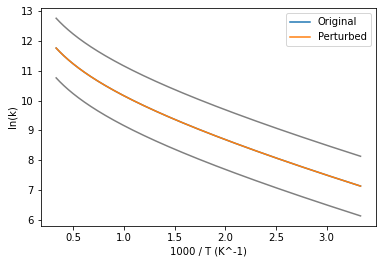

Arrhenius(A=(7.1018e+07,'cm^3/(mol*s)'), n=0.97, Ea=(1.586,'kcal/mol'), T0=(1,'K'))


In [18]:
print(reaction_list[288])
print(reaction_list[288].kinetics)

rxn288 = copy.copy(reaction_list[288])
rxn288_2 = copy.copy(reaction_list[288])
perturb_reaction(rxn288_2, -6)

plot_reaction_perturbation(rxn288, rxn288_2, 1.0)

print(rxn288_2.kinetics)